# Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd
import os
from osgeo import gdal
from scipy.interpolate import interp1d
from scipy import signal
from scipy.interpolate import interp2d, NearestNDInterpolator
import seaborn as sns
import seaborn.objects as so
import csv

from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

%matplotlib inline
plt.rcParams['font.sans-serif'] = 'Arial' # Choose a nice font here
plt.rcParams['font.size'] = 7 # standard font size
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.rm'] = 'Arial'
plt.rcParams['mathtext.it'] = 'Arial'
plt.rcParams['figure.facecolor'] = 'white' # make sure background isn't transparent
plt.rcParams['figure.dpi'] = 100

print(os.getcwd())


C:\Users\ptrck\EAE_Intensive\MEDEAS_2024


# Draft Check

In [2]:
#Draft true for figure border
#draft false to print and save plots
draft = False

# Definitions

In [3]:
# ellipse plotting function taken from MatPlotLib documentation example library

def confidence_ellipse(x, y, ax, n_std=3.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.

    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    **kwargs
        Forwarded to `~matplotlib.patches.Ellipse`

    Returns
    -------
    matplotlib.patches.Ellipse
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensional dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the standard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the standard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

In [4]:
d = []
with open('wood23.txt') as source:
    for line in source:
        fields = line.split('\t')
        d.append(fields)
d = np.array(d)   
#-------------------------------------------------------------------------------------
d2 = []
with open('wood23_2.txt') as source:
    for line in source:
        fields = line.split('\t')
        d2.append(fields)
d2 = np.array(d2)   

In [5]:
new_d = np.delete(d, np.s_[4],axis=1)

new_d2 = np.delete(d2, np.s_[4],axis=1)

In [6]:
df = pd.DataFrame(new_d, columns=new_d[0,:])
df = df.drop(0)
df2 = pd.DataFrame(new_d2, columns=new_d2[0,:])
df2 = df2.drop(0)

In [7]:
df = df.astype(float)
df2 = df2.astype(float)

In [8]:
mean = df.groupby(pd.cut(df['age'], (8400,8800))).mean()
var =  df.groupby(pd.cut(df['age'], (8400,8800))).var()
std = df.groupby(pd.cut(df['age'], (8400,8800))).std()
min_ = df.groupby(pd.cut(df['age'], (8400,8800))).min()
max_ = df.groupby(pd.cut(df['age'], (8400,8800))).max()
minC = df.groupby(pd.cut(df['age'], (8400,8800))).min()
maxC = df.groupby(pd.cut(df['age'], (8400,8800))).max()

min_ = min_.iloc[0]['d18O']
max_ = max_.iloc[0]['d18O']
d18O_2sig = 2*std.iloc[0]['d18O']
d18Omean = mean.iloc[0]['d18O']
d18O_significant = d18Omean + d18O_2sig
d18O_5sig = d18Omean + 5*std.iloc[0]['d18O']

minC = minC.iloc[0]['d13C']
maxC = maxC.iloc[0]['d13C']
d13C_2sig = 2*std.iloc[0]['d13C']
d13Cmean = mean.iloc[0]['d13C']
d13C_significant = d13Cmean - d13C_2sig
d13C_5sig = d13Cmean - 5*std.iloc[0]['d13C']

sdf = df[df['age'].between(8000, 8400)]
sdf1 = df[df['age'].between(7930,8360)]

In [9]:
win=50
df['ages'] = df['age'].rolling(window=win).mean()
df['d18Os'] = df['d18O'].rolling(window=win).mean()
df['d13Cs'] = df['d13C'].rolling(window=win).mean()
df['d18Ov'] = df['d18O'].rolling(window=win).std()
df['d13Cv'] = df['d13C'].rolling(window=win).std()

control_df = df[df['age'].between(8400,8800)]
cCm  =  control_df['d13C'].mean()
cOm  =  control_df['d18O'].mean()
cCstd  =  control_df['d13C'].std()
cOstd  =  control_df['d18O'].std()
cmin, cmax =  control_df['d13Cs'].min() , control_df['d13Cs'].max()
omin, omax =  control_df['d18Os'].min() , control_df['d18Os'].max()

# Plots

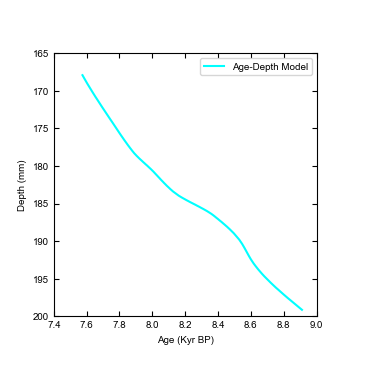

In [10]:

pltspan = 0.75
sdif = (1-pltspan)/2
ax0l,ax0b,ax0w,ax0h = sdif,sdif,pltspan,pltspan

fig = plt.gcf()
ax00 = fig.add_axes([0,0,1,1])
if draft:
    plt.xticks([])
    plt.yticks([])
else:
    plt.axis('off')


ax = fig.add_axes([ax0l,ax0b,ax0w,ax0h])
ax.set_xlim(7.4,9)
ax.set_ylim(200,165)
ax.plot(df['age']/1000,df['depth'],rasterized=True,label="Age-Depth Model",color='cyan')
ax.set_xlabel("Age (Kyr BP)")
ax.set_ylabel("Depth (mm)")
ax.tick_params('x', top=True,bottom=True,direction='in')
ax.tick_params('y', right=True,left=True,direction='in')
fig.set_size_inches(89/25.4,89/25.4)
plt.legend()
if draft==False:
    plt.savefig('Age_Depth_Plot.pdf',dpi=300)
    plt.savefig('Age_Depth_Plot.png',dpi=300)

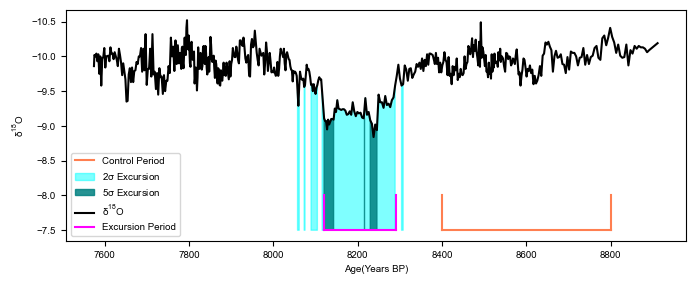

In [11]:
fig, ax1 = plt.subplots(figsize=(8,3))
color = 'black'
ax1.set_xlabel('Age(Years BP)')
ax1.set_ylabel("$\delta^{18}O$",color=color)

ax1.tick_params(axis='y',color=color)
ax1.invert_yaxis()
#ax1.axvspan(8400, 8800, alpha=0.3, color='coral',label="Control Period")
ax1.plot((8400,8800),(-7.5,-7.5),color="coral",label="Control Period")
ax1.plot((8400,8400),(-8,-7.5),color="coral")
ax1.plot((8800,8800),(-8,-7.5),color="coral")
ax1.fill_between(sdf['age'],sdf['d18O'],(np.full(len(np.array(sdf['age'])),-7.5)),where=sdf['d18O']>=d18O_significant,color='cyan',alpha=0.5,label="2$\sigma$ Excursion")

ax1.fill_between(sdf['age'],sdf['d18O'],(np.full(len(np.array(sdf['age'])),-7.5)),where=sdf['d18O']>=d18O_5sig,color='teal',alpha=0.85,label="5$\sigma$ Excursion")
ax1.plot(df['age'],df['d18O'], color=color,label="$\delta^{18}O$")

ax1.plot((8120,8290),(-7.5,-7.5),color="magenta",label="Excursion Period")
ax1.plot((8120,8120),(-8,-7.5),color="magenta")
ax1.plot((8290,8290),(-8,-7.5),color="magenta")


ax1.legend()

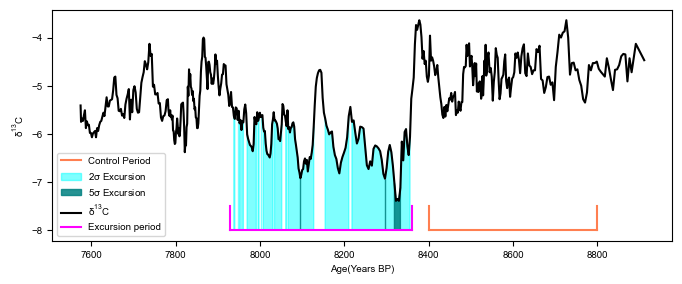

In [12]:
fig, ax2 = plt.subplots(figsize=(8,3))
color = 'black'
ax2.set_xlabel('Age(Years BP)')
ax2.set_ylabel("$\delta^{13}C$",color=color)

ax2.tick_params(axis='y',color=color)

#ax1.axvspan(8400, 8800, alpha=0.3, color='cyan',label="Control Period")
#ax1.axvspan(8112,8290, alpha=0.3, color='magenta')
ax2.plot((8400,8800),(-8,-8),color="coral",label="Control Period")
ax2.plot((8400,8400),(-8,-7.5),color="coral")
ax2.plot((8800,8800),(-8,-7.5),color="coral")
ax2.fill_between(sdf1['age'],sdf1['d13C'],(np.full(len(np.array(sdf1['age'])),-8)),where=sdf1['d13C']<=d13C_significant,color='cyan',alpha=0.5,label="2$\sigma$ Excursion")

ax2.fill_between(sdf1['age'],sdf1['d13C'],(np.full(len(np.array(sdf1['age'])),-8)),where=sdf1['d13C']<=d13C_5sig,color='teal',alpha=0.85,label="5$\sigma$ Excursion")
ax2.plot(df['age'],df['d13C'], color=color,label="$\delta^{13}C$")

ax2.plot((7930,8360),(-8,-8),color="magenta",label="Excursion period")
ax2.plot((7930,7930),(-8,-7.5),color="magenta")
ax2.plot((8360,8360),(-8,-7.5),color="magenta")

ax2.legend()

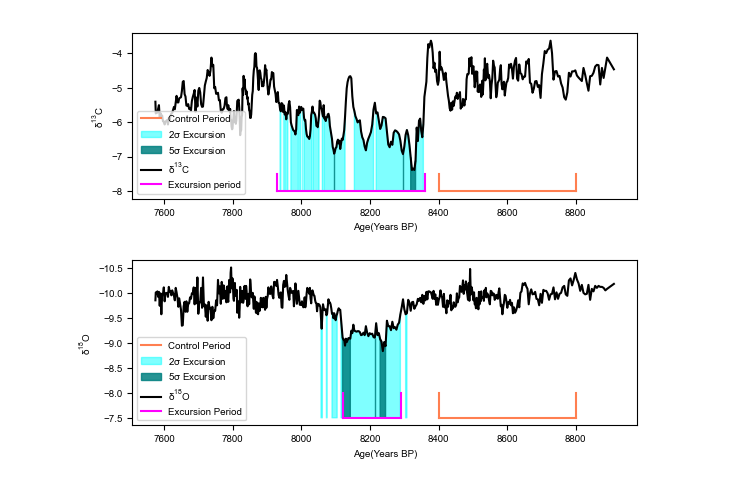

In [20]:

pltspan = 0.7
plth = 0.35
ax0l,ax0b,ax0w,ax0h = 0.17,0.12,pltspan,plth


fig = plt.gcf()
ax00 = fig.add_axes([0,0,1,1])
if draft:
    plt.xticks([])
    plt.yticks([])
else:
    plt.axis('off')

#----------------------------------------------------------------------------

ax1 = fig.add_axes([ax0l,ax0b,ax0w,ax0h])
color = 'black'
ax1.set_xlabel('Age(Years BP)')
ax1.set_ylabel("$\delta^{18}O$",color=color)

ax1.tick_params(axis='y',color=color)
ax1.invert_yaxis()
#ax1.axvspan(8400, 8800, alpha=0.3, color='coral',label="Control Period")
ax1.plot((8400,8800),(-7.5,-7.5),color="coral",label="Control Period")
ax1.plot((8400,8400),(-8,-7.5),color="coral")
ax1.plot((8800,8800),(-8,-7.5),color="coral")
ax1.fill_between(sdf['age'],sdf['d18O'],(np.full(len(np.array(sdf['age'])),-7.5)),where=sdf['d18O']>=d18O_significant,color='cyan',alpha=0.5,label="2$\sigma$ Excursion")

ax1.fill_between(sdf['age'],sdf['d18O'],(np.full(len(np.array(sdf['age'])),-7.5)),where=sdf['d18O']>=d18O_5sig,color='teal',alpha=0.85,label="5$\sigma$ Excursion")
ax1.plot(df['age'],df['d18O'], color=color,label="$\delta^{18}O$")

ax1.plot((8120,8290),(-7.5,-7.5),color="magenta",label="Excursion Period")
ax1.plot((8120,8120),(-8,-7.5),color="magenta")
ax1.plot((8290,8290),(-8,-7.5),color="magenta")


ax1.legend(loc=3)

#----------------------------------------------------------------------------
ax1l,ax1b,ax1w,ax1h = 0.17,0.6,pltspan,plth
ax2 = fig.add_axes([ax1l,ax1b,ax1w,ax1h])
color = 'black'
ax2.set_xlabel('Age(Years BP)')
ax2.set_ylabel("$\delta^{13}C$",color=color)

ax2.tick_params(axis='y',color=color)

ax2.plot((8400,8800),(-8,-8),color="coral",label="Control Period")
ax2.plot((8400,8400),(-8,-7.5),color="coral")
ax2.plot((8800,8800),(-8,-7.5),color="coral")
ax2.fill_between(sdf1['age'],sdf1['d13C'],(np.full(len(np.array(sdf1['age'])),-8)),where=sdf1['d13C']<=d13C_significant,color='cyan',alpha=0.5,label="2$\sigma$ Excursion")

ax2.fill_between(sdf1['age'],sdf1['d13C'],(np.full(len(np.array(sdf1['age'])),-8)),where=sdf1['d13C']<=d13C_5sig,color='teal',alpha=0.85,label="5$\sigma$ Excursion")
ax2.plot(df['age'],df['d13C'], color=color,label="$\delta^{13}C$")

ax2.plot((7930,8360),(-8,-8),color="magenta",label="Excursion period")
ax2.plot((7930,7930),(-8,-7.5),color="magenta")
ax2.plot((8360,8360),(-8,-7.5),color="magenta")

ax2.legend(loc=3)




fig.set_size_inches(183/25.4,120/25.4)

if draft==False:
    plt.savefig('Stable_Isotope_Excursion.pdf',dpi=3000)
    plt.savefig('Stable_Isotope_Excursion.png',dpi=300)



In [14]:
df['nage'] = df['age']
df['ndepth'] = df['depth']
df['growth'] = df['depth']
for i in range(513):
    if i >=1:
        df.nage[i] = df.age[i+1]-df.age[i]
        df.ndepth[i] = df.depth[i+1]-df.depth[i]
        df.growth[i] =   (df.ndepth[i] / df.nage[i])*1000
growthdf = df.drop(513, axis=0)
growthdf
growthdf['growth_avg'] = growthdf['growth'].rolling(window=25).mean()
growthdf['age_avg'] = growthdf['age'].rolling(window=25).mean()
growthdf['growth_dv'] = growthdf['growth'].rolling(window=25).std()
growthdf['age_dv'] = growthdf['age'].rolling(window=25).std()

upper = np.array(growthdf['growth_avg'] + 2*growthdf['growth_dv'] )
lower = np.array(growthdf['growth_avg'] - 2*growthdf['growth_dv'] )

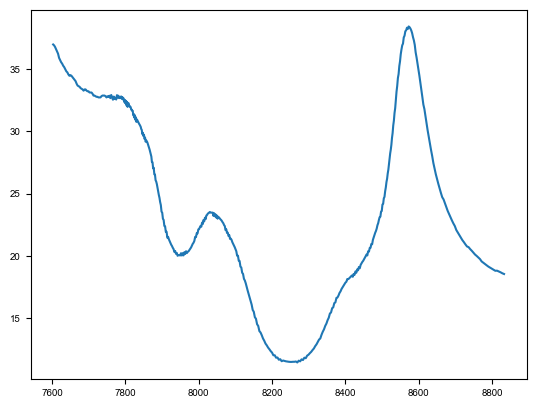

In [15]:
plt.plot(growthdf['age_avg'],growthdf['growth_avg'])

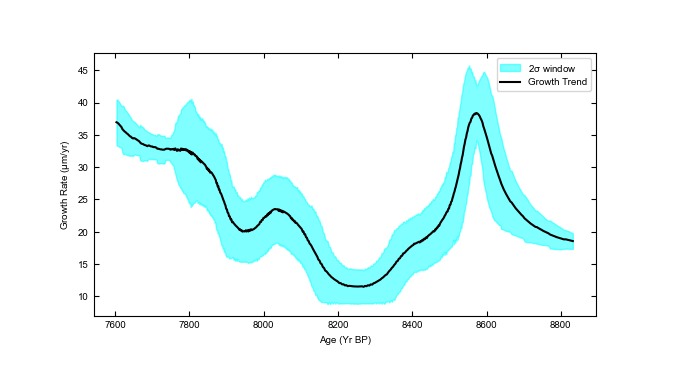

In [16]:

pltspan = 0.75
sdif = (1-pltspan)/2
ax0l,ax0b,ax0w,ax0h = sdif,sdif,pltspan,pltspan


fig = plt.gcf()
ax00 = fig.add_axes([0,0,1,1])
if draft:
    plt.xticks([])
    plt.yticks([])
else:
    plt.axis('off')


ax = fig.add_axes([ax0l,ax0b,ax0w,ax0h])
ax.fill_between(growthdf['age_avg'],lower,upper,color="cyan",alpha=0.5,label="$2\sigma$ window")
ax.plot(growthdf['age_avg'],growthdf['growth_avg'],color="black",label="Growth Trend")
ax.set_xlabel("Age (Yr BP)")
ax.set_ylabel("Growth Rate ($\mu m/yr$)")
ax.tick_params('x', top=True,bottom=True,direction='in')
ax.tick_params('y', right=True,left=True,direction='in')
fig.set_size_inches(170/25.4,89/25.4)
plt.legend()


if draft==False:
    plt.savefig('Growth_Rate.pdf',dpi=300)
    plt.savefig('Growth_Rate.png',dpi=300)

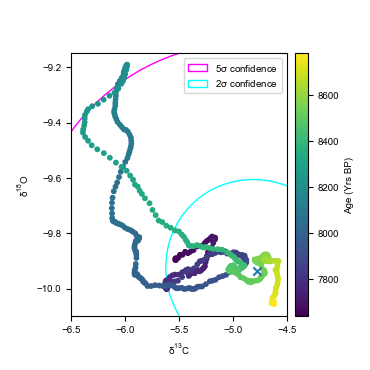

In [17]:

pltspan = 0.75
sdif = (1-pltspan)/2
ax0l,ax0b,ax0w,ax0h = sdif+0.05,sdif,pltspan,pltspan

fig = plt.gcf()
ax00 = fig.add_axes([0,0,1,1])
if draft:
    plt.xticks([])
    plt.yticks([])
else:
    plt.axis('off')
#-----------------------------------------------------------------------------------------------------------------------
ax = fig.add_axes([ax0l,ax0b,ax0w,ax0h])
#confidence areas, defined by st. devs of d13C & d18O from the control period
confidence_ellipse(control_df['d13C'], control_df['d18O'],ax,n_std=5,edgecolor='magenta',label="$5\sigma$ confidence")
confidence_ellipse(control_df['d13C'], control_df['d18O'],ax,n_std=2,edgecolor='cyan',label="$2\sigma$ confidence")
#stable isotope date scatter, rolling average of 30 points

#plot limits
plt.ylim(-10.1,-9.15)
plt.xlim(-6.5,-4.5)

s = ax.scatter(df['d13Cs'],df['d18Os'],c=df.ages,s=10)

#centre of ellipse, the mean of d13C & d18O in the control period
plt.scatter(cCm,cOm,marker='x')




fig.set_size_inches(89/25.4,89/25.4)
ax.set_ylabel("$\delta^{18}O$")
ax.set_xlabel("$\delta^{13}C$")

fig.colorbar(s, orientation="vertical",pad=0.03,label='Age (Yrs BP)')
ax.legend(loc=1,ncols=1)
if draft==False:
    plt.savefig('iso_space.pdf',dpi=300)
    plt.savefig('iso_space.png',dpi=300)
